IMPORT ALL THE REQUIRED LIBRARIES

In [25]:
import os
import time
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from scipy import linalg
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import HTML
import torchvision.utils as utils
from torch.utils.data import Subset
import torchvision.models as models
import torchvision.datasets as datasets
import matplotlib.animation as animation
import torchvision.transforms as transforms

DEFINE THE PARAMETERS

In [26]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LEARNING_RATE = 4e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64 
FEATURES_GEN = 64 
NUM_CLASSES = 10
EMBED_SIZE = 100
criticItr = 5

LOAD THE DATASET

In [27]:
dataset = datasets.CIFAR10(root="./CIFAR_dataset/CIFAR10data", download=False,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [28]:
class Generator(nn.Module):
    def __init__(self, num_classes, img_size,embed_size,channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            nn.ConvTranspose2d(NOISE_DIM+embed_size,features_g* 16, 4, 1, 0, bias = False),   
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1), 
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),  
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1), 
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )
        
        self.embed = nn.Embedding(num_classes, embed_size)

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)

In [29]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size,channels_img, features_d):    
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self.Dnet(features_d, features_d * 2, 4, 2, 1),     
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1), 
        )
        self.validity_layer = nn.Sequential(
            nn.Conv2d(512,1,4,1,0,bias = False),
                               nn.Sigmoid())
        
        self.labels = nn.Sequential(
            nn.Conv2d(512, 11, 4, 1, 0, bias = False), 
            nn.LogSoftmax(dim = 1)
                                        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)
        

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )
    


    def forward(self, x):
        x = self.disc(x)
        valid = self.validity_layer(x).view(-1)
        label = self.labels(x).view(-1,11)
        return valid,label

In [30]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [31]:
gen = Generator(NUM_CLASSES, IMAGE_SIZE,EMBED_SIZE,NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(NUM_CLASSES, IMAGE_SIZE,CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [32]:
gen.train() , disc.train()

(Generator(
   (net): Sequential(
     (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (5): Tanh()
   )
   (embed): Embedding(10, 100)
 ),
 Discriminato

In [33]:
class InceptionV3(nn.Module):

    DEFAULT_BLOCK_INDEX = 3

    BLOCK_INDEX_BY_DIM = {
        64: 0, 
        192: 1,
        768: 2,
        2048: 3 
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
    """get fretched distance"""
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [34]:
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
step = 0

In [35]:
disOptim = optim.Adam(disc.parameters(),LEARNING_RATE, betas = (0.5,0.999))
genOptim = optim.Adam(gen.parameters(), LEARNING_RATE, betas = (0.5,0.999))
criterion = nn.BCELoss()
counterList = []
counter = 0
genLossList = []
disLossList = []
img_list = []

In [36]:
GenLoss = []
DiscLoss = []
img_list = []
iters = 0
FID_list = []
print("=============== Training Started =================")
time_start = time.time() 

for epoch in range(NUM_EPOCHS):
    epoch = epoch+1
    print(f"Starting Epoch {epoch}/{NUM_EPOCHS}")
    
    epoch_gen_loss = 0.0
    epoch_disc_loss = 0.0
    
    for batch_idx, (realImg,labels) in enumerate(dataloader):
        real = realImg.to(device)
        labels = labels.to(device)
        miniBatch = real.shape[0]
        fakeClassLabel =  10*torch.ones((miniBatch,),dtype = torch.long).to(device)        
        disc.zero_grad()
        
        r_label =  torch.full((miniBatch,), 1.0, dtype=torch.float).to(device)
        disc_real, disc_label = disc(real)
        loss_disc_realVal = criterion(disc_real, r_label)
        discRealLabelLoss = F.nll_loss(disc_label, labels) 
        realLoss_disc = loss_disc_realVal + discRealLabelLoss
        realLoss_disc.backward()
        
        sampleLabel = torch.randint(0, 10, (miniBatch,), dtype = torch.long).to(device)
        noise = torch.randn(miniBatch, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise,sampleLabel) 
        disc_fake, disc_fLabel = disc(fake.detach())
        r_label.fill_(0.0)
        loss_disc_fakelVal = criterion(disc_fake, r_label)
        discFakeLabelLoss = F.nll_loss(disc_fLabel, fakeClassLabel) 
        fakeLoss_disc = loss_disc_fakelVal + discFakeLabelLoss
        fakeLoss_disc.backward()
        loss_disc = (realLoss_disc+fakeLoss_disc)/2
        disOptim.step()
        
        gen.zero_grad()
        noise = torch.randn(miniBatch, NOISE_DIM, 1, 1).to(device)
        sampleLabel = torch.randint(0,10,(miniBatch,),dtype = torch.long).to(device)
        r_label.fill_(1.0)
        fake = gen(noise, sampleLabel)
        genOutput, genOutputLabel = disc(fake)
        
        loss_gen_r = criterion(genOutput, r_label)
        genLabelLoss = F.nll_loss(genOutputLabel, sampleLabel)
        loss_gen = loss_gen_r + genLabelLoss
        loss_gen.backward()
        genOptim.step()
        
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())
        
        epoch_gen_loss += loss_gen.item()
        epoch_disc_loss += loss_disc.item()
        
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(noise,sampleLabel).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            print(f"Iteration {iters}: Saving sample images")
            
        iters += 1
        
    
    fretchet_dist = calculate_fretchet(real,fake,model)
    FID_list.append(fretchet_dist)
    
    print(f"Epoch {epoch} Summary:")
    print(f"Average Generator Loss: {epoch_gen_loss/len(dataloader):.4f}")
    print(f"Average Discriminator Loss: {epoch_disc_loss/len(dataloader):.4f}")
    print(f"FID Score: {fretchet_dist:.4f}")
    
    images = gen(noise,sampleLabel).detach()
    utils.save_image(images.detach(),'Results/ACGAN_FAKE/ACGAN_epoch_%03d.png' % (epoch), normalize = True)
    utils.save_image(real.detach(),'Results/ACGAN_REAL/ACGAN_epoch_%03d.png' % (epoch), normalize = True)
    print(f"Saved images for epoch {epoch}")
        
time_end = time.time()
print('Elapsed time: %.2f seconds'%(time_end-time_start))

=============== Training Started =================
Starting Epoch 1/40
Iteration 0: Saving sample images
Iteration 500: Saving sample images
Epoch 1 Summary:
Average Generator Loss: 7.1975
Average Discriminator Loss: 1.3420
FID Score: 330.2885
Saved images for epoch 1
Starting Epoch 2/40
Iteration 1000: Saving sample images
Iteration 1500: Saving sample images
Epoch 2 Summary:
Average Generator Loss: 3.4352
Average Discriminator Loss: 1.7796
FID Score: 325.0795
Saved images for epoch 2
Starting Epoch 3/40
Iteration 2000: Saving sample images
Epoch 3 Summary:
Average Generator Loss: 2.7640
Average Discriminator Loss: 1.9964
FID Score: 379.9384
Saved images for epoch 3
Starting Epoch 4/40
Iteration 2500: Saving sample images
Iteration 3000: Saving sample images
Epoch 4 Summary:
Average Generator Loss: 2.5866
Average Discriminator Loss: 2.0636
FID Score: 450.9926
Saved images for epoch 4
Starting Epoch 5/40
Iteration 3500: Saving sample images
Epoch 5 Summary:
Average Generator Loss: 2.53

In [37]:
np.save('Results/Loss_Data/ACGAN_GLoss', GenLoss) 
np.save('Results/Loss_Data/ACGAN_DLoss', DiscLoss) 

In [38]:
GenLoss = np.load('Results/Loss_Data/ACGAN_GLoss.npy')
DiscLoss = np.load('Results/Loss_Data/ACGAN_DLoss.npy')

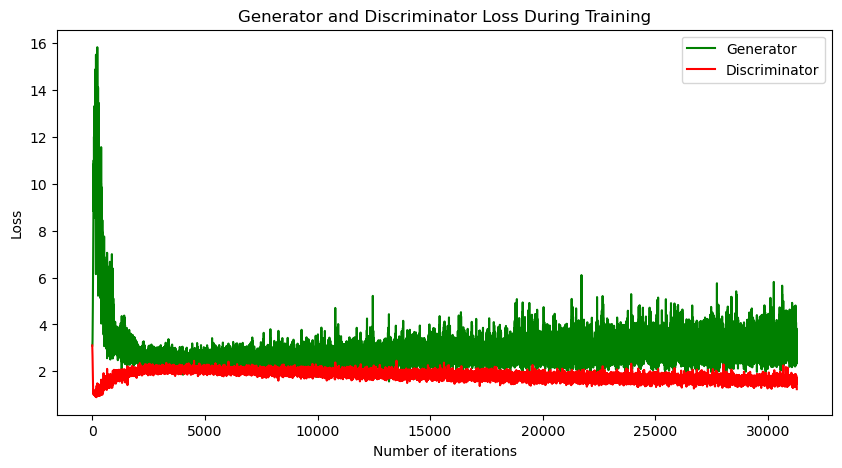

In [39]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Generator", color='green')
plt.plot(DiscLoss,label="Discriminator", color='red')
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

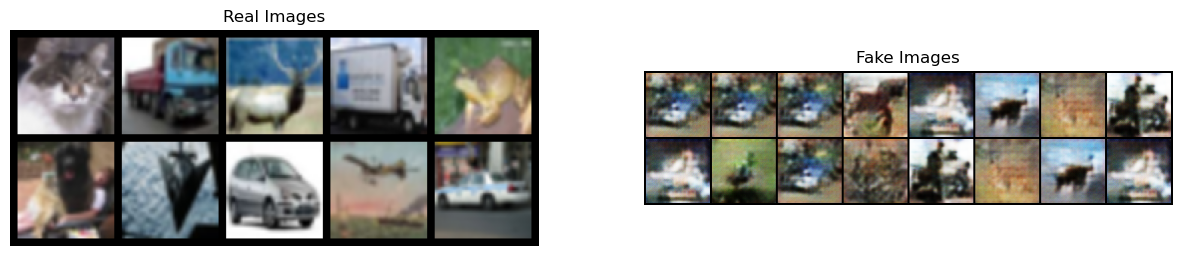

In [40]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10], nrow=5,ncol=2,padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

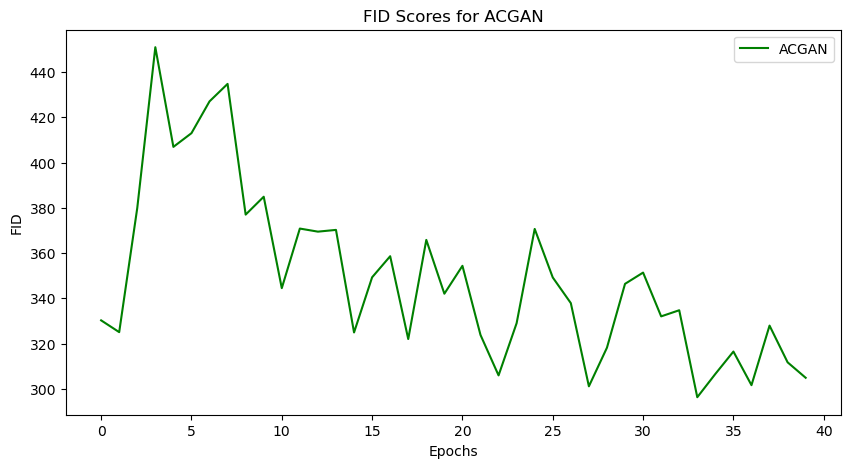

In [41]:
plt.figure(figsize=(10,5))
plt.title("FID Scores for ACGAN")
plt.plot(FID_list,label="ACGAN", color='green')
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.show()

In [42]:
np.min(FID_list), np.max(FID_list), np.mean(FID_list), FID_list[-5]
np.mean(GenLoss),np.mean(DiscLoss),np.min(GenLoss),np.min(DiscLoss),GenLoss[-1],DiscLoss[-1]

(2.9495819, 1.816151, 1.5651276, 0.89467055, 3.40739, 1.238419)